## 0. Import Libraries

In [41]:
from shapely.geometry import mapping

import xarray as xr
import numpy as np
import geopandas as gpd

import cartopy

## 1. 50th Percentile Analysis

In [27]:
path_general = r'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'
q=0.50

### 1.1 Open Data

In [3]:
# change these
season = 'DJF'
# ----------------------------------------------

time_resample = 6
# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# variable name
name_variable_cosmo = 'TOT_PREC'
name_variable_era5 = 'tp'

#### 1.1.1 Model

In [4]:
dt_model = xr.open_dataset(fr'{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_{path_resample}_198501_200512.nc',
                     #chunks={"time": -1}
                          )[name_variable_cosmo]

In [5]:
dt_model

<xarray.DataArray 'TOT_PREC' (time: 7601, rlat: 107, rlon: 175)>
[142328725 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 ... 2005-12-31T18:00:00
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
  * rlon     (rlon) float32 -8.3 -8.19 -8.08 -7.97 ... 10.51 10.62 10.73 10.84
  * rlat     (rlat) float32 -6.2 -6.09 -5.98 -5.87 -5.76 ... 5.13 5.24 5.35 5.46

#### 1.1.2 ERA5

In [18]:
dt_era5 = xr.open_dataset(fr'{path_general}/era5/era5_TOT_PREC_{season}_{path_resample}_1985_2005.nc',
                     #chunks={"time": -1}
                         )[name_variable_era5]*1e3

In [19]:
dt_era5

<xarray.DataArray 'tp' (time: 7601, latitude: 41, longitude: 93)>
array([[[5.75697049e-03, 2.78605148e-03, 1.48592517e-03, ...,
         2.76705250e-02, 2.76705250e-02, 3.00845131e-02],
        [2.09850259e-02, 1.33709982e-02, 1.00284815e-02, ...,
         2.52560712e-02, 2.71131285e-02, 3.13846394e-02],
        [3.10130417e-02, 2.43275426e-02, 1.94995664e-02, ...,
         3.13846394e-02, 2.80416571e-02, 3.24989669e-02],
        ...,
        [1.24424696e-02, 2.71131285e-02, 2.58134678e-02, ...,
         4.65661287e-07, 4.65661287e-07, 4.65661287e-07],
        [3.11428219e-01, 2.97129154e-01, 2.24518120e-01, ...,
         4.65661287e-07, 4.65661287e-07, 4.65661287e-07],
        [4.42536533e-01, 2.49402598e-01, 1.73077911e-01, ...,
         4.65661287e-07, 4.65661287e-07, 4.65661287e-07]],

       [[1.22589990e-02, 9.84501094e-03, 7.80168921e-03, ...,
         3.04558784e-01, 2.88587987e-01, 3.10315281e-01],
        [6.20270148e-02, 3.43564898e-02, 2.54432671e-02, ...,
         2.42533162e-01, 2.13934571e-01, 2.37890512e-01],
        [1.15882605e-01, 7.31693581e-02, 3.99281271e-02, ...,
         3.98525953e-01, 2.46803746e-01, 1.59151390e-01],
...
        [2.79396772e-06, 2.79396772e-06, 2.79396772e-06, ...,
         2.79396772e-06, 2.79396772e-06, 2.79396772e-06],
        [2.79396772e-06, 2.79396772e-06, 2.79396772e-06, ...,
         2.79396772e-06, 2.79396772e-06, 2.79396772e-06],
        [2.79396772e-06, 2.79396772e-06, 2.79396772e-06, ...,
         2.79396772e-06, 2.79396772e-06, 2.79396772e-06]],

       [[2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 1.11619011e-03],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 1.11619011e-03],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 3.53017822e-03],
        ...,
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 2.32830644e-06],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 2.32830644e-06],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 2.32830644e-06]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 ... 2005-12-31T18:00:00
  * longitude  (longitude) float32 24.0 24.25 24.5 24.75 ... 46.5 46.75 47.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0

### 1.2. Assign Projection

In [60]:
def assign_proj_to_model(dt_model):
    
    # define globe
    globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis=6370000,
                          semiminor_axis=6370000)
    
    # projection info
    dt_proj = xr.open_dataset(fr'data/lffd2100123118.nc')
    
    # fetch model projection info
    rotated_pole = dt_proj['rotated_pole']
    pole_longitude = rotated_pole.attrs['grid_north_pole_longitude']
    pole_latitude = rotated_pole.attrs['grid_north_pole_latitude']
    
    # define model projection
    proj_model = cartopy.crs.RotatedPole(pole_longitude=pole_longitude,
                                   pole_latitude=pole_latitude,
                                   globe=globe
                                   )
    
    # x and y dims
    dt_x_dim_model = 'rlon'
    dt_y_dim_model = 'rlat'

    # write projection
    dt_model = dt_model.rio.write_crs(proj_model)

    # set spatial dims
    dt_model = dt_model.rio.set_spatial_dims(x_dim=dt_x_dim_model,
                                             y_dim=dt_y_dim_model)
    
    return dt_model

def assign_proj_to_era5(dt_era5):
    
    # define observation projection
    proj_obs = cartopy.crs.CRS('EPSG:4326',
                              )
    
    # x and y dims
    dt_x_dim_obs = 'longitude'
    dt_y_dim_obs = 'latitude'

    # write projection
    dt_era5 = dt_era5.rio.write_crs(proj_obs)

    # set spatial dims
    dt_era5 = dt_era5.rio.set_spatial_dims(x_dim=dt_x_dim_obs,
                                           y_dim=dt_y_dim_obs)
    
    return dt_era5

In [63]:
dt_model = assign_proj_to_model(dt_model)
dt_era5 = assign_proj_to_era5(dt_era5)

### 1.3 Calculate Percentile

#### 1.3.1 Model

In [64]:
dt_model_q50 = dt_model.groupby('time.year')\
                       .sum(dim='time')\
                       .quantile(q,
                               dim='year',
                                )

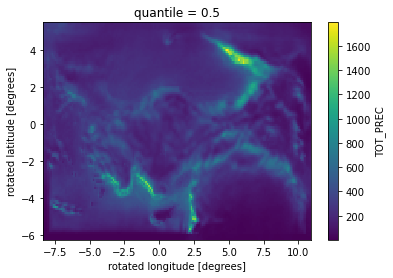

In [56]:
dt_model_q50.plot()

#### 1.3.2 ERA5

In [66]:
dt_era5_q50 = dt_era5.groupby('time.year')\
                     .sum(dim='time')\
                     .quantile(q,
                               dim='year',
                                )

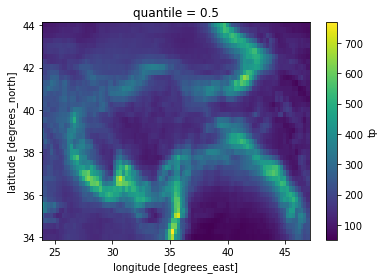

In [67]:
dt_era5_q50.plot()

### 1.4 Clip to Turkey

In [68]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [69]:
path_shape = fr'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_tr = gpd.read_file(path_shape)

#### 1.4.1 Model

In [70]:
dt_model_q50_clipped = clip_to_city(assign_proj_to_model(dt_model_q50), shape_tr)

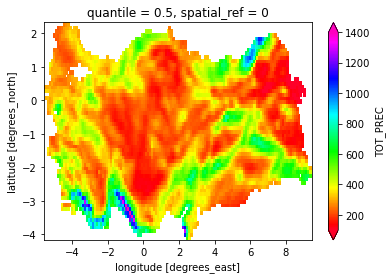

In [80]:
dt_model_q50_clipped.plot(cmap='gist_rainbow', vmin=100, vmax=1400)

#### 1.4.2 ERA5

In [72]:
dt_era5_q50_clipped = clip_to_city(assign_proj_to_era5(dt_era5_q50), shape_tr)

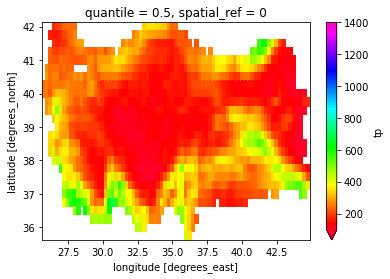

In [81]:
dt_era5_q50_clipped.plot(cmap='gist_rainbow', vmin=100, vmax=1400)